In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
## configuration

embed_size = 300 # how big is each word vector
max_features = 120000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 120 # max number of words in a question to use
batch_size = 512 # how many samples to process at once
n_epochs = 50 # how many times to iterate over all samples

dataset_path = "/content/drive/MyDrive/Datasets/hateXplain/"
data_filename = 'dataset.json'
class_labels_filename = 'classes.npy'
embeddings_file_path = dataset_path + 'glove.840B.300d.txt'
max_words = 10000
embedding_dim = 300


In [13]:
'''
Convert json data to a dataframe
1. convert json to dataframe
2. Voting resolution
3. Remove text samples that have 'undecided' class label
'''

import pandas as pd
import numpy as np
import json

def get_data(dataset_path, data_filename, class_labels_filename):

  data_path = dataset_path + data_filename
  class_labels_path = dataset_path + class_labels_filename

  with open(data_path, 'r') as f:
    data = json.load(f)
  data_dictionary = []
  for key in data:
    buffer = {}
    buffer['post'] = data[key]['post_tokens']
    final_label = []

    for i in range(1, 4):
      final_label.append(data[key]['annotators'][i-1]['label'])
    
    final_label_id = max(final_label, key = final_label.count)
    buffer['rationales'] = data[key]['rationales']

    if(final_label.count(final_label_id) == 1):
      continue
    else:
      buffer['label'] = final_label_id
    
    data_dictionary.append(buffer)
  return pd.DataFrame(data_dictionary)

In [14]:
data = get_data(dataset_path=dataset_path, data_filename=data_filename, class_labels_filename=class_labels_filename)


In [15]:
data.head()	

,post,rationales,label
0,"[i, dont, think, im, getting, my, baby, them, ...",[],normal
1,"[we, cannot, continue, calling, ourselves, fem...",[],normal
2,"[nawt, yall, niggers, ignoring, me]",[],normal
3,"[<user>, i, am, bit, confused, coz, chinese, p...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",hatespeech
4,"[this, bitch, in, whataburger, eating, a, burg...","[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",hatespeech


In [16]:
one_hot = pd.get_dummies(data['label'])
data = data.drop('label',axis = 1)
data = data.join(one_hot)

In [17]:
'''
Text Data Preprocessing
1. Remove Special Characters
2. Remove Numbers
3. Convert Contractions to Expanded Words
'''

import re

def remove_special_chars(str):
  patt = r'[^a-zA-z0-9\s]'
  text = re.sub(patt, ' ', str)
  return str

def remove_numbers(str):
  if bool(re.search(r'\d', str)):
    str = re.sub('[0-9]*', '', str)
  return str

contraction_dict = {"lets": "let us", 
                    "aint" : "are not",
                    "yall": "you all",
                    "im": "i am",
                    "heres": "here is",
                    "youre": "you are",
                    "hes": "he is",
                    "its": "it is",
                    "shes": "she is",
                    "theyre": "they are",
                    "ill": "i will",
                    "youll": "you will",
                    "itll": "it will", 
                    "ive": "i have",
                    "shouldve": "should have",
                    "youve": "you have",
                    "couldve": "could have",
                    "theyve": "they have",
                    "id": "i would",
                    "weve": "we have",
                    "theyd": "they would",
                    "youd": "you would",
                    "hed": "he would",
                    "didnt": "did not",
                    "dont": "do not",
                    "doesnt": "does not",
                    "cant": "cannot",
                    "isnt": "is not",
                    "arent": "are not",
                    "shouldnt": "should not",
                    "couldnt": "could not",
                    "wouldnt": "would not",
                    "hasnt": "has not",
                    "wasnt": "was not",
                    "wont": "will not",
                    "werent": "were not",
                    "theyre": "they are",
                    "wheres": "where is",
                    "coz": "because",
                    "thiss": "this is"
                    }

def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re
contractions, contractions_re = _get_contractions(contraction_dict)
def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)
 

In [18]:
cleaned_posts = []
for index, row in data.iterrows():
  post = row['post']
  cleaned_post = ''
  for i in range(0, len(post)):
    word = post[i]
    word = remove_special_chars(word)
    word = remove_numbers(word)
    word = replace_contractions(word)
    word = word.strip()
    cleaned_post = cleaned_post + word + ' '
  
  cleaned_posts.append(cleaned_post)

cleaned_posts = np.array(cleaned_posts)
data['posts'] = cleaned_posts

In [20]:
data = data.drop(['post'], axis = 1)

In [21]:
data.head()

,rationales,hatespeech,normal,offensive,posts
0,[],0,1,0,i do not think i am getting my baby them white...
1,[],0,1,0,we cannot continue calling ourselves feminists...
2,[],0,1,0,nawt you all niggers ignoring me
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1,0,0,<user> i am bit confused because chinese ppl c...
4,"[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1,0,0,this bitch in whataburger eating a burger with...


In [22]:
y_cols = list(data.columns[1:4])
print(y_cols)
is_multilabel = (data[y_cols].sum(axis=1) >1).count()

['hatespeech', 'normal', 'offensive']


In [23]:
def get_class_weight(data):
    class_weight = {}
    for num,col in enumerate(y_cols):
        if num not in class_weight:
            class_weight[col] = round((data[data[col] == 1][col].sum())/data.shape[0]*100,2)
    return class_weight
class_weight = get_class_weight(data)
print('Total class weight: ', sum(class_weight.values()), '%\n\n', class_weight)

Total class weight:  100.0 %

 {'hatespeech': 30.86, 'normal': 40.64, 'offensive': 28.5}


In [24]:
data.head()

,rationales,hatespeech,normal,offensive,posts
0,[],0,1,0,i do not think i am getting my baby them white...
1,[],0,1,0,we cannot continue calling ourselves feminists...
2,[],0,1,0,nawt you all niggers ignoring me
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1,0,0,<user> i am bit confused because chinese ppl c...
4,"[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1,0,0,this bitch in whataburger eating a burger with...


In [25]:
from sklearn.model_selection import train_test_split
def get_train_test_val(data):
    X_data = data['posts'].values
    y_data = data[list(data.columns[1:4])].values
    X, X_test, y, y_test = train_test_split(X_data, y_data, test_size=0.1, train_size=0.9)
    #X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, train_size=0.5)

    X_train = X
    y_train = y

    print(
        'X_train shape', X_train.shape,
        '\ny_train shape', y_train.shape,
        '\nX_test shape', X_test.shape,
        '\ny_test shape', y_test.shape,
    )
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_val(data)

X_train shape (17306,) 
y_train shape (17306, 3) 
X_test shape (1923,) 
y_test shape (1923, 3)


In [26]:
'''
  Tokenizing and Pad_Sequence
'''

# from keras.preprocessing.text import Tokenizer
# from keras_preprocessing.sequence import pad_sequences

# texts = data['post'] 
# texts = list(texts)

# tokenizer = Tokenizer(num_words = max_words)
# tokenizer.fit_on_texts(texts) # Convert to integers by assigining an integer to each word

# sequences = tokenizer.texts_to_sequences(texts) # Transform each text to a sequence of integers by keeping only the top num_wrds-1 most frequent words into account
# word_index = tokenizer.word_index

# # Number of samples in the validation dataset
# validation_samples = int((len(data) // 10))

# # Pad Sequences to convert to a 2D array
# df = pad_sequences(sequences, maxlen = maxlen) 

'\n  Tokenizing and Pad_Sequence\n'

In [27]:
validation_samples = 1922

In [28]:
# functions for reading in embedding data and
# tokenizing and processing sequences with padding and
# function for plotting model accuracy and loss

import os
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

# vectorizer and sequence function
# takes in raw text and labels
# params for max sequence length and max words
# default arg for Shuffle=True to randomise data
# returns tokenizer object. x_train,y_train, x_val,y_val
def tokenize_and_sequence(full_data_set, texts, labels, max_len, max_words, validation_samples, shuffle=True):
    #initialise tokenizer with num_words param
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(full_data_set)
    # convert texts to sequences
    sequences = tokenizer.texts_to_sequences(texts)
    # generate work index
    word_index = tokenizer.word_index
    # print top words count
    print('{} of unique tokens found'.format(len(word_index)))
    # pad sequences using max_len param
    data = pad_sequences(sequences, maxlen=max_len)
    # convert list of labels into numpy array
    labels = np.asarray(labels)
    # print shape of text and label tensors
    print('data tensor shape: {}\nlabel tensor shape:{}'.format(data.shape, labels.shape))

    # shuffle data=True as labels are ordered
    # randomise data to vary class distribution
    if shuffle:
        # get length of data sequence and create array
        indices = np.arange(data.shape[0])
        np.random.shuffle(indices)
        # shuffle data and labels
        data = data[indices]
        labels = labels[indices]
    else:
        pass

    # split training data into training and validation splits
    # split using validation length
    # validation split
    x_val = data[:validation_samples]
    y_val = labels[:validation_samples]

    # training split
    x_train = data[validation_samples:]
    y_train = labels[validation_samples:]

    # return tokenizer, word_index, training and validation data
    return tokenizer, word_index, x_train, y_train, x_val, y_val


tokenizer, word_index, X_train, y_train, X_val, y_val = tokenize_and_sequence(
    data['posts'], X_train, y_train, max_len=maxlen, max_words=max_words, validation_samples=validation_samples, shuffle=False)

# function to lpad pretrained glove embeddings
# takes in embedding dim for variable embedding sizes
# and base directory as well as txt file
# embedding dim should match the file name dimension
# and max words and word_index for embedding features
'''
Glove Embeddings to Vectorize Text
'''

from sklearn.utils import validation


f = open(embeddings_file_path)
embeddings_index = {}

for line in f:
  values = line.split(" ")
  word = values[0]
  coeff = np.asarray(values[1:], dtype = 'float32')
  embeddings_index[word] = coeff
f.close()

embedding_matrix = np.zeros((max_words,embedding_dim ))

for word, i in word_index.items():
  if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

glove_embedding_300d = embedding_matrix


# function to visualise keras model history metrics
# function takes in acc, val_acc, loss, val_loss for model params
# range is defined by epochs in range len(acc)

import matplotlib.pyplot as plt

def plot_training_and_validation(acc, val_acc, loss, val_loss):
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

# end

27363 of unique tokens found
data tensor shape: (17306, 120)
label tensor shape:(17306, 3)


In [29]:
    print(
        'X_train shape', X_train.shape,
        '\ny_train shape', y_train.shape,
        '\nX_val shape', X_val.shape,
        '\ny_val shape', y_val.shape,
        '\nX_test shape', X_test.shape,
        '\ny_test shape', y_test.shape,
    )

X_train shape (15384, 120) 
y_train shape (15384, 3) 
X_val shape (1922, 120) 
y_val shape (1922, 3) 
X_test shape (1923,) 
y_test shape (1923, 3)


In [30]:
# import layers
from keras.layers import Input, Embedding, GRU, LSTM, MaxPooling1D, GlobalMaxPool1D
from keras.layers import Dropout, Dense, Activation, Flatten,Conv1D, SpatialDropout1D
from keras.models import Sequential
from keras.optimizers import RMSprop 

In [31]:
# import AUC ROC metrics from sklearn
from sklearn.metrics import roc_auc_score
# import keras layers 
from keras.layers import Input, Embedding, GRU, LSTM, MaxPooling1D, GlobalMaxPool1D, CuDNNGRU, CuDNNLSTM
from keras.layers import Dropout, Dense, Activation, Flatten,Conv1D, Bidirectional, SpatialDropout1D, BatchNormalization
from keras.models import Sequential
from keras.optimizers import RMSprop 

In [32]:
# import AUC ROC metrics from sklearn
import keras
from sklearn.metrics import roc_auc_score

# define class for ROC AUC callback with simple name modifications
# credit to https://www.kaggle.com/yekenot
class roc_auc_validation(keras.callbacks.Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()
        self.interval = interval
        self.x_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.x_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: {:d} - score: {:.6f}".format(epoch+1, score))

In [33]:
# define model architecture

'''
MODEL_1
'''
model_1 = Sequential()
model_1.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model_1.add(Conv1D(64, 3, activation='relu'))
model_1.add(MaxPooling1D(4))
model_1.add(GRU(64, dropout=0.1, recurrent_dropout=0.5)) # defaults inclide tanh activation
model_1.add(Dense(3, activation='sigmoid'))
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 300)          3000000   
                                                                 
 conv1d (Conv1D)             (None, 118, 64)           57664     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 29, 64)           0         
 )                                                               
                                                                 
 gru (GRU)                   (None, 64)                24960     
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 3,082,819
Trainable params: 3,082,819
Non-trainable params: 0
______________________________________________

In [34]:
'''
MODEL_2
'''

# highest performing architecture
# baseline++ with shorter convolution kernel of 3
# define model architecture
model_2 = Sequential()
model_2.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model_2.add(SpatialDropout1D(0.2)) # add spatial dropout
model_2.add(Conv1D(64, 3, activation='relu')) # kernel size to 3
model_2.add(MaxPooling1D(4))
model_2.add(BatchNormalization()) # add batch normalization
model_2.add(Dropout(0.1))
# modify to CuDNNGRU
model_2.add(GRU(64, dropout=0.1, recurrent_dropout=0.5)) # defaults inclide tanh activation
# model_2.add(CuDNNGRU(64)) # does not have a dropout or recurrent dropout param
model_2.add(BatchNormalization())
model_2.add(Dropout(0.1))
model_2.add(Dense(3, activation='sigmoid'))
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 120, 300)          3000000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 120, 300)         0         
 ropout1D)                                                       
                                                                 
 conv1d_1 (Conv1D)           (None, 118, 64)           57664     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 29, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 29, 64)           256       
 ormalization)                                                   
                                                      

In [35]:
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

roc_callback = roc_auc_validation(validation_data=(X_val, y_val), interval=1)
callback_list = [keras.callbacks.EarlyStopping(monitor='accuracy', patience=1), 
                 keras.callbacks.ModelCheckpoint(filepath='baseline_plus_complex.h5', monitor='val_loss', save_best_only=True)]
callback_list.append(roc_callback)



In [36]:
'''
###################
###################
###################
###################

MODEL INITIALIZATION

###################
###################
###################
###################
'''

model = model_2

In [37]:
# load pre-trained Glove embeddings in the first layer
model.layers[0].set_weights([glove_embedding_300d])
# freeze embedding layer weights
model.layers[0].trainable = False
# compile model with adam optimizer
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [38]:
# fit model and train on training data and validate on validation samples
# train for 5 epochs to establish baseline overfitting model
# saves results to histroy object
history = model.fit(X_train, y_train, epochs=30, batch_size=32, callbacks=callback_list, validation_data=(X_val, y_val))

Epoch 1/30
481/481 [==============================] - ETA: 0s - loss: 0.6124 - accuracy: 0.5150
 ROC-AUC - epoch: 1 - score: 0.750858
481/481 [==============================] - 42s 81ms/step - loss: 0.6124 - accuracy: 0.5150 - val_loss: 0.5288 - val_accuracy: 0.5869
Epoch 2/30
481/481 [==============================] - ETA: 0s - loss: 0.5256 - accuracy: 0.5978
 ROC-AUC - epoch: 2 - score: 0.772101
481/481 [==============================] - 38s 79ms/step - loss: 0.5256 - accuracy: 0.5978 - val_loss: 0.5134 - val_accuracy: 0.6077
Epoch 3/30
481/481 [==============================] - ETA: 0s - loss: 0.5050 - accuracy: 0.6172
 ROC-AUC - epoch: 3 - score: 0.775805
481/481 [==============================] - 38s 79ms/step - loss: 0.5050 - accuracy: 0.6172 - val_loss: 0.5107 - val_accuracy: 0.6129
Epoch 4/30
481/481 [==============================] - ETA: 0s - loss: 0.4895 - accuracy: 0.6368
 ROC-AUC - epoch: 4 - score: 0.780973
481/481 [==============================] - 38s 79ms/step - loss: 

### Model Results

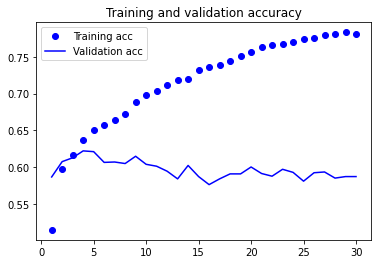

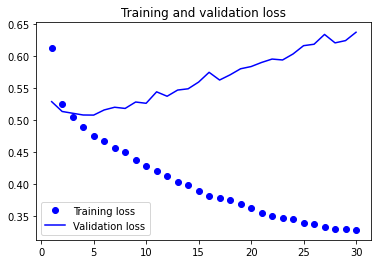

In [39]:
# define plotting metrics
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
# plot model training and validation accuracy and loss
plot_training_and_validation(acc, val_acc, loss, val_loss)

In [40]:
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen=maxlen)

In [41]:
y_hat = model.predict(X_test, batch_size=256)

8/8 [==============================] - 1s 100ms/step


In [42]:
y_hat.shape

(1923, 3)

In [43]:
y_prediction = []
for i in range(0, y_hat.shape[0]):
  a = y_hat[i][0]
  b = y_hat[i][1]
  c = y_hat[i][2]

  if(a >= b and a >= c):
    y_prediction.append([1, 0, 0])
  elif(b >= a and b >= c):
    y_prediction.append([0, 1, 0])
  elif(c >= a and c >= b):
    y_prediction.append([0, 0, 1])

y_prediction = np.array(y_prediction)

In [44]:
y_prediction.shape

(1923, 3)

Text(69.0, 0.5, 'Actual_labels')

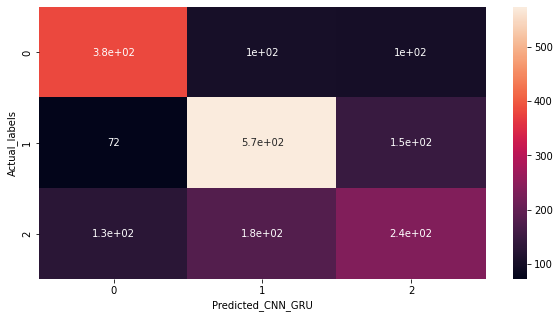

In [45]:
'''
  Confusion Matrix for CNN-GRU Model
'''

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
confusion_mat = confusion_matrix(
    y_test.argmax(axis=1), y_prediction.argmax(axis=1))

import seaborn as sns
plt.subplots(figsize=(10,5))
sns.heatmap(confusion_mat, annot=True)
plt.xlabel('Predicted_CNN_GRU')
plt.ylabel('Actual_labels')

In [46]:
data.loc[data['offensive'] == 1]

,rationales,hatespeech,normal,offensive,posts
7,"[[1, 1, 1, 1, 0, 0], [1, 1, 0, 1, 0, 0], [1, 1...",0,0,1,nogs jews and dykes how enriching
14,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,...",0,0,1,all of my exes were cute but they were hoes i ...
19,"[[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, ...",0,0,1,<user> condoning drug use not kike at all than...
27,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0,0,1,that was just a photo look up rhyan moody she ...
29,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0,0,1,i saw a couple baums and steins in the victi a...
...,...,...,...,...,...
19222,"[[0, 1, 1, 1], [0, 1, 1, 1]]",0,0,1,a negro honey trap
19223,"[[0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,...",0,0,1,this vile racist ghetto ass dumber than a reta...
19224,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,...",0,0,1,if ur sti will on twitter tell carlton i sai w...
19225,"[[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,...",0,0,1,when i first got on here and sai would i hate ...


In [47]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

def print_evaluation_scores(y_test, predicted):
    
    print('Accuracy: ', accuracy_score(y_test, y_prediction, normalize=True))
    print('F1-score macro: ', f1_score(y_test, y_prediction, average='macro'))
    print('F1-score micro: ', f1_score(y_test, y_prediction, average='micro'))
    print('F1-score weighted: ', f1_score(y_test, y_prediction, average='weighted'))
    print('Precision macro: ', average_precision_score(y_test, y_prediction, average='macro'))
    print('Precision micro: ', average_precision_score(y_test, y_prediction, average='micro'))
    print('Precision weighted: ', average_precision_score(y_test, y_prediction, average='weighted'))
    
print('CNN-GRU\n')
print_evaluation_scores(y_test, y_hat)

CNN-GRU

Accuracy:  0.6203848153926157
F1-score macro:  0.6035744874791301
F1-score micro:  0.6203848153926157
F1-score weighted:  0.6167750047240811
Precision macro:  0.5019906909960107
Precision micro:  0.511415714038858
Precision weighted:  0.5154278696420271
